In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd

In [21]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [37]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [23]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True) 


In [25]:
# We can view all of the classes that automap found
Base.classes.keys() 


['measurement', 'station']

In [98]:
# Let's look at it another way and see our columns
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
print("-----")
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [26]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Precipitation Analysis

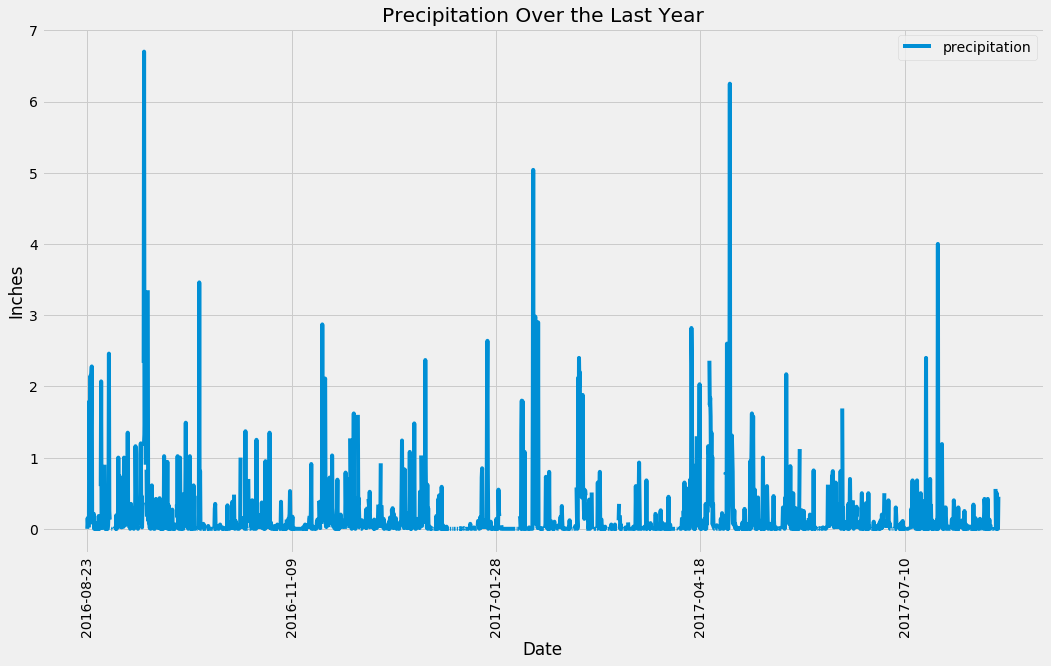

In [91]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first() 
 
# Calculate the date 1 year ago from the last data point in the database
# Last data point is 2017-08-23
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_year_rainfall = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_year_rainfall, columns=['date','prcp'])
last_year_df.set_index('date', inplace=True)

# Sort the dataframe by date
last_year_df = last_year_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
last_year_df.plot.line(figsize=(16,9),title='Precipitation Over the Last Year')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(['precipitation'],loc='best')
#plt.xticks(np.arange(min(last_year_df['date']), max(last_year_df['date']), 1.0))
plt.xticks(rotation=90)
plt.show()

In [65]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [94]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [146]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all() 
station_activity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

#### Analysis: Station with highest # of observations = USC00519281

In [151]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Get the first station's id from station_activity
station_id = station_activity[0][0]

# Filter the data
USC00519281_min = session.query(func.min(Measurement.tobs)).filter(Measurement.station == station_id).all()
USC00519281_max = session.query(func.max(Measurement.tobs)).filter(Measurement.station == station_id).all()
USC00519281_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_id).all()

# Get the values from the filtered data
min_temp = [x[0] for x in USC00519281_min][0]
max_temp = [x[0] for x in USC00519281_max][0]
avg_temp = [x[0] for x in USC00519281_avg][0]

# Print results
print(f'For station {station_id}, min temp= {min_temp}, max temp= {max_temp}, and avg temp= {round(avg_temp,2)}.')

For station USC00519281, min temp= 54.0, max temp= 85.0, and avg temp= 71.66.


In [155]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

USC00519281_last_year_data = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.station == station_id).all()
USC00519281_last_year_data


USC00519281_df = pd.DataFrame(USC00519281_last_year_data, columns=['date','prcp'])


Frequency and Temp

[('USC00519281', '2016-08-23', 77.0),
 ('USC00519281', '2016-08-24', 77.0),
 ('USC00519281', '2016-08-25', 80.0),
 ('USC00519281', '2016-08-26', 80.0),
 ('USC00519281', '2016-08-27', 75.0),
 ('USC00519281', '2016-08-28', 73.0),
 ('USC00519281', '2016-08-29', 78.0),
 ('USC00519281', '2016-08-30', 77.0),
 ('USC00519281', '2016-08-31', 78.0),
 ('USC00519281', '2016-09-01', 80.0),
 ('USC00519281', '2016-09-02', 80.0),
 ('USC00519281', '2016-09-03', 78.0),
 ('USC00519281', '2016-09-04', 78.0),
 ('USC00519281', '2016-09-05', 78.0),
 ('USC00519281', '2016-09-06', 73.0),
 ('USC00519281', '2016-09-07', 74.0),
 ('USC00519281', '2016-09-08', 80.0),
 ('USC00519281', '2016-09-09', 79.0),
 ('USC00519281', '2016-09-10', 77.0),
 ('USC00519281', '2016-09-11', 80.0),
 ('USC00519281', '2016-09-12', 76.0),
 ('USC00519281', '2016-09-13', 79.0),
 ('USC00519281', '2016-09-14', 75.0),
 ('USC00519281', '2016-09-15', 79.0),
 ('USC00519281', '2016-09-16', 78.0),
 ('USC00519281', '2016-09-17', 79.0),
 ('USC005192

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
